In [1]:
%matplotlib inline
import numpy as np
import paddle
import paddle.fluid as fluid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


z_dim = 100
batch_size = 128
step_per_epoch = 60000 / batch_size

In [2]:
def generator(z, name="G"):
    with fluid.unique_name.guard(name+'_'):
        fc1 = fluid.layers.fc(input = z, size = 1024)
        fc1 = fluid.layers.fc(fc1, size = 128 * 7 * 7)
        fc1 = fluid.layers.batch_norm(fc1,act = 'relu')
        fc1 = fluid.layers.reshape(fc1, shape=(-1, 128, 7, 7))

    
        conv1 = fluid.layers.conv2d(fc1, num_filters = 4*64,
                                    filter_size=5, stride=1, 
                                    padding=2, act='relu')
        conv1 = fluid.layers.reshape(conv1, shape=(-1,64,14,14))
        
        conv2 = fluid.layers.conv2d(conv1, num_filters = 4*32, 
                                    filter_size=5, stride=1,
                                    padding=2, act='relu')
        conv2 = fluid.layers.reshape(conv2, shape=(-1,32,28,28))
        
        conv3 = fluid.layers.conv2d(conv2, num_filters = 1, 
                                    filter_size=5, stride=1,
                                    padding=2,act='relu')
#         conv3 = fluid.layers.reshape(conv3, shape=(-1,1,28,28))
        print("conv3",conv3)
        return conv3
        

In [3]:
def discriminator(image, name="D"):
    with fluid.unique_name.guard(name+'_'):
        conv1 = fluid.layers.conv2d(input=image, num_filters=32,
                                    filter_size=6, stride=2,
                                    padding=2)
        conv1_act = fluid.layers.leaky_relu(conv1)
        
        conv2 = fluid.layers.conv2d(conv1_act, num_filters=64, 
                                    filter_size=6, stride=2,
                                    padding=2)
        conv2 = fluid.layers.batch_norm(conv2)
        conv2_act = fluid.layers.leaky_relu(conv2)
        
        fc1 = fluid.layers.reshape(conv2_act, shape=(-1,64*7*7))
        fc1 = fluid.layers.fc(fc1, size=512)
        fc1_bn = fluid.layers.batch_norm(fc1)
        fc1_act = fluid.layers.leaky_relu(fc1_bn)
        
        #有没有sigmoid的act???
        fc2 = fluid.layers.fc(fc1_act, size=1, act='sigmoid')
        print("fc2",fc2)
        return fc2

In [4]:
def get_params(program, prefix):
    all_params = program.global_block().all_parameters()
    return [t.name for t in all_params if t.name.startswith(prefix)]

In [5]:
#优化generator
G_program = fluid.Program()
with fluid.program_guard(G_program):
    z = fluid.layers.data(name='z', shape=[z_dim,1,1])
    # 用生成器G生成样本图片
    G_sample = generator(z)
    infer_program = G_program.clone(for_test=True)
    # 用判别器D判别生成的样本
    D_fake = discriminator(G_sample)
    
#     ones = fluid.layers.fill_constant_batch_size_like(z, shape=[-1, 1], dtype='float32', value=1)
    # G损失
    # G Least square cost
    G_loss = fluid.layers.reduce_mean(fluid.layers.square(D_fake-1))/2.
    # 获取G的参数
    G_params = get_params(G_program, "G")
    
    # 使用Adam优化器
    G_optimizer = fluid.optimizer.Adam(learning_rate=0.0002)
    # 训练G
    G_optimizer.minimize(G_loss,parameter_list = G_params)
    print(G_params)

('conv3', name: "G_G_conv2d_2.tmp_1"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 1
      dims: 28
      dims: 28
    }
    lod_level: 0
  }
}
persistable: false
)
('fc2', name: "D_D_fc_1.tmp_1"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 1
    }
    lod_level: 0
  }
}
persistable: false
)
['G_G_fc_0.w_0', 'G_G_fc_0.b_0', 'G_G_fc_1.w_0', 'G_G_fc_1.b_0', 'G_G_batch_norm_0.w_0', 'G_G_batch_norm_0.b_0', 'G_G_batch_norm_0.w_1', 'G_G_batch_norm_0.w_2', 'G_G_conv2d_0.w_0', 'G_G_conv2d_0.b_0', 'G_G_conv2d_1.w_0', 'G_G_conv2d_1.b_0', 'G_G_conv2d_2.w_0', 'G_G_conv2d_2.b_0']


In [6]:
# 优化discriminator
D_program = fluid.Program()
with fluid.program_guard(D_program):
    z = fluid.layers.data(name='z', shape=[z_dim,1,1])
    # 用生成器G生成样本图片
    G_sample = generator(z)
    real = fluid.layers.data(name='img', shape=[1, 28, 28])
    # 用判别器D判别真实的样本
    D_real = discriminator(real)
    # 用判别器D判别生成的样本
    D_fake = discriminator(G_sample)
    # D损失
    print("D_real",D_real)
    print("D_fake",D_fake)
    # D Least square cost
    D_loss = fluid.layers.reduce_mean(fluid.layers.square(D_real-1.)+fluid.layers.square(D_fake))/2.
    print("D_loss",D_loss)
    # 获取D的参数列表
    D_params = get_params(D_program, "D")
    # 使用Adam优化
    D_optimizer = fluid.optimizer.Adam(learning_rate=0.0002)
    D_optimizer.minimize(D_loss, parameter_list = D_params)
    print(D_params)

('conv3', name: "G_G_conv2d_2.tmp_1"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 1
      dims: 28
      dims: 28
    }
    lod_level: 0
  }
}
persistable: false
)
('fc2', name: "D_D_fc_1.tmp_1"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 1
    }
    lod_level: 0
  }
}
persistable: false
)
('fc2', name: "D_D_fc_1.tmp_1"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 1
    }
    lod_level: 0
  }
}
persistable: false
)
('D_real', name: "D_D_fc_1.tmp_1"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 1
    }
    lod_level: 0
  }
}
persistable: false
)
('D_fake', name: "D_D_fc_1.tmp_1"
type {
  type: LOD_TENSOR
  lod_tensor {
    tensor {
      data_type: FP32
      dims: -1
      dims: 1
    }
    lod_level: 0
  }
}
persistable: false
)
('D_loss', name: "tmp_8"
typ

In [7]:
def show_image_grid(images, epoch=None): # images.shape = (64, 1, 28, 28)
    fig = plt.figure(figsize=(5, 5))
    fig.suptitle("Epoch {}".format(epoch))
    gs = plt.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, image in enumerate(images[:64]):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
#         plt.imshow(image[0], cmap='Greys_r')
        plt.imshow(image[0], cmap='Greys_r')
    plt.show()

In [8]:
batch_size = 128
step_per_epoch = 60000 / batch_size

# 噪声生成
def z_reader():
    while True:
        yield np.random.normal(0.0, 1.0, (z_dim, 1, 1)).astype('float32')

In [9]:
# MNIST数据集，不使用label
def mnist_reader(reader):
    def r():
        for img, label in reader():
            yield img.reshape(1, 28, 28)
    return r

mnist_generator = paddle.batch(
    paddle.reader.shuffle(mnist_reader(paddle.dataset.mnist.train()), 1024), batch_size=batch_size)
z_generator = paddle.batch(z_reader, batch_size=batch_size)()

In [10]:
place = fluid.CUDAPlace(0) if fluid.core.is_compiled_with_cuda() else fluid.CPUPlace()
exe = fluid.Executor(place)
exe.run(program=fluid.default_startup_program())

[]

In [11]:
np.random.seed(0)
test_z = np.array(next(z_generator))
#print("test_z",test_z) 

Epoch 0 batch 0 d 0.29655623436 g 0.0844825804234
Epoch 0 batch 50 d 0.268069863319 g 0.128258392215
Epoch 0 batch 100 d 0.263306766748 g 0.128795430064
Epoch 0 batch 150 d 0.260744452477 g 0.128499254584
Epoch 0 batch 200 d 0.258742272854 g 0.127977967262
Epoch 0 batch 250 d 0.257224023342 g 0.127478018403
Epoch 0 batch 300 d 0.256105542183 g 0.127144768834
Epoch 0 batch 350 d 0.255280852318 g 0.126879051328
Epoch 0 batch 400 d 0.254652529955 g 0.126665577292
Epoch 0 batch 450 d 0.254160434008 g 0.1265052706


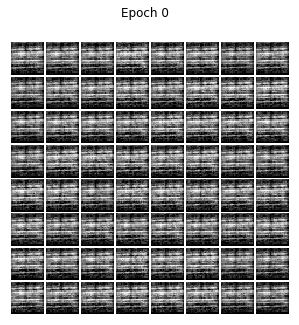

Epoch 1 batch 0 d 0.250235408545 g 0.125720024109
Epoch 1 batch 50 d 0.250285297632 g 0.125377729535
Epoch 1 batch 100 d 0.25031003356 g 0.125257521868
Epoch 1 batch 150 d 0.250425517559 g 0.125223606825
Epoch 1 batch 200 d 0.25058811903 g 0.125361353159
Epoch 1 batch 250 d 0.250791043043 g 0.125562518835
Epoch 1 batch 300 d 0.250898450613 g 0.125608190894
Epoch 1 batch 350 d 0.250917196274 g 0.12565369904
Epoch 1 batch 400 d 0.250915914774 g 0.12560865283
Epoch 1 batch 450 d 0.250939577818 g 0.125588238239


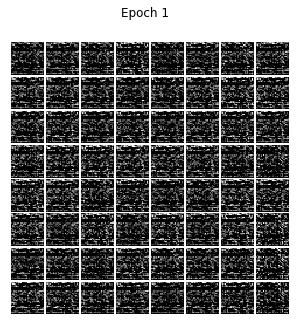

Epoch 2 batch 0 d 0.250561445951 g 0.125459313393
Epoch 2 batch 50 d 0.250763267279 g 0.126070693135
Epoch 2 batch 100 d 0.250721633434 g 0.125509381294
Epoch 2 batch 150 d 0.250799179077 g 0.125555023551
Epoch 2 batch 200 d 0.250944137573 g 0.125702381134
Epoch 2 batch 250 d 0.251259386539 g 0.125559046865
Epoch 2 batch 300 d 0.251070410013 g 0.125531613827
Epoch 2 batch 350 d 0.250941038132 g 0.125493317842
Epoch 2 batch 400 d 0.250861734152 g 0.125484064221
Epoch 2 batch 450 d 0.250931501389 g 0.12551496923


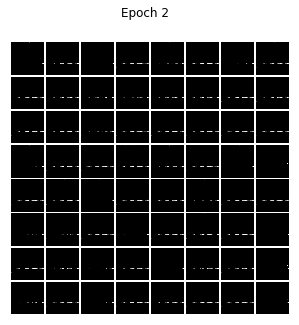

Epoch 3 batch 0 d 0.250633090734 g 0.130482420325
Epoch 3 batch 50 d 0.250314831734 g 0.125907287002
Epoch 3 batch 100 d 0.250707477331 g 0.126132532954
Epoch 3 batch 150 d 0.250529557467 g 0.125712394714
Epoch 3 batch 200 d 0.250414133072 g 0.125524163246
Epoch 3 batch 250 d 0.250339955091 g 0.125432595611
Epoch 3 batch 300 d 0.250296592712 g 0.12537547946
Epoch 3 batch 350 d 0.250269562006 g 0.125321254134
Epoch 3 batch 400 d 0.250297933817 g 0.125337898731
Epoch 3 batch 450 d 0.250269412994 g 0.125294849277


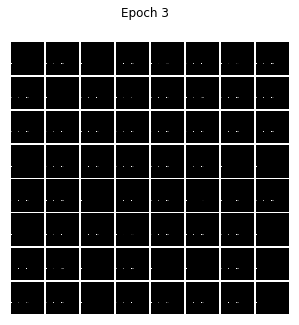

Epoch 4 batch 0 d 0.250030577183 g 0.125351786613
Epoch 4 batch 50 d 0.250048667192 g 0.12492659688
Epoch 4 batch 100 d 0.250035822392 g 0.125003650784
Epoch 4 batch 150 d 0.250028342009 g 0.125032916665
Epoch 4 batch 200 d 0.250023543835 g 0.125034704804
Epoch 4 batch 250 d 0.250020295382 g 0.125037193298
Epoch 4 batch 300 d 0.250017493963 g 0.125031322241
Epoch 4 batch 350 d 0.250015348196 g 0.125028640032
Epoch 4 batch 400 d 0.250013887882 g 0.125022187829
Epoch 4 batch 450 d 0.250013589859 g 0.125020310283


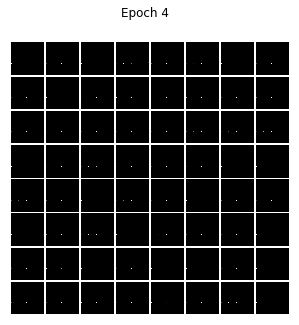

Epoch 5 batch 0 d 0.250007152557 g 0.124981701374
Epoch 5 batch 50 d 0.250005185604 g 0.125053480268
Epoch 5 batch 100 d 0.250004410744 g 0.125015005469
Epoch 5 batch 150 d 0.250003784895 g 0.125003769994
Epoch 5 batch 200 d 0.25000411272 g 0.125007718801
Epoch 5 batch 250 d 0.25019839406 g 0.125153899193
Epoch 5 batch 300 d 0.250268667936 g 0.125244617462
Epoch 5 batch 350 d 0.250230997801 g 0.125215008855
Epoch 5 batch 400 d 0.250202357769 g 0.125190719962
Epoch 5 batch 450 d 0.25018003583 g 0.125168755651


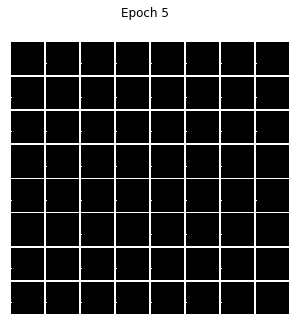

Epoch 6 batch 0 d 0.250000417233 g 0.125094234943
Epoch 6 batch 50 d 0.250000685453 g 0.125014409423
Epoch 6 batch 100 d 0.250000685453 g 0.125007838011
Epoch 6 batch 150 d 0.250000685453 g 0.125002831221
Epoch 6 batch 200 d 0.250000625849 g 0.125002533197
Epoch 6 batch 250 d 0.250000596046 g 0.12500436604
Epoch 6 batch 300 d 0.250000596046 g 0.125007614493
Epoch 6 batch 350 d 0.250000685453 g 0.125007435679
Epoch 6 batch 400 d 0.250000745058 g 0.125007838011
Epoch 6 batch 450 d 0.250000715256 g 0.125005751848


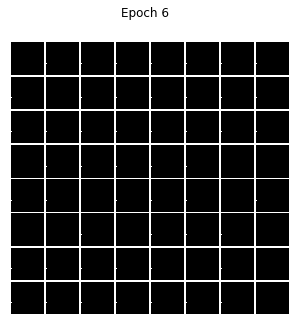

Epoch 7 batch 0 d 0.250000178814 g 0.124998226762
Epoch 7 batch 50 d 0.250000566244 g 0.12500846386
Epoch 7 batch 100 d 0.250000506639 g 0.125012770295
Epoch 7 batch 150 d 0.250000447035 g 0.12501104176
Epoch 7 batch 200 d 0.250000506639 g 0.125010564923
Epoch 7 batch 250 d 0.250000476837 g 0.125009015203
Epoch 7 batch 300 d 0.250000476837 g 0.125008016825
Epoch 7 batch 350 d 0.250000536442 g 0.125009968877
Epoch 7 batch 400 d 0.250000536442 g 0.125009655952
Epoch 7 batch 450 d 0.250000506639 g 0.125007912517


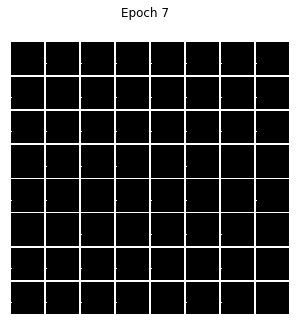

Epoch 8 batch 0 d 0.250000804663 g 0.125276133418
Epoch 8 batch 50 d 0.250000566244 g 0.124986991286
Epoch 8 batch 100 d 0.250000447035 g 0.12499755621
Epoch 8 batch 150 d 0.250000506639 g 0.125005945563
Epoch 8 batch 200 d 0.250000536442 g 0.125005483627
Epoch 8 batch 250 d 0.250000536442 g 0.125006020069
Epoch 8 batch 300 d 0.250000506639 g 0.125005304813
Epoch 8 batch 350 d 0.250000447035 g 0.125003695488
Epoch 8 batch 400 d 0.250000447035 g 0.125004410744
Epoch 8 batch 450 d 0.250000417233 g 0.125005871058


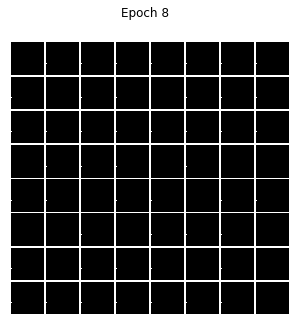

Epoch 9 batch 0 d 0.250000208616 g 0.124726638198
Epoch 9 batch 50 d 0.250000238419 g 0.125001862645
Epoch 9 batch 100 d 0.250000238419 g 0.124999783933
Epoch 9 batch 150 d 0.250000357628 g 0.125000581145
Epoch 9 batch 200 d 0.25000038743 g 0.125003144145
Epoch 9 batch 250 d 0.250000417233 g 0.125004157424
Epoch 9 batch 300 d 0.250000417233 g 0.125002473593
Epoch 9 batch 350 d 0.25000038743 g 0.125004068017
Epoch 9 batch 450 d 0.250000357628 g 0.12500333786


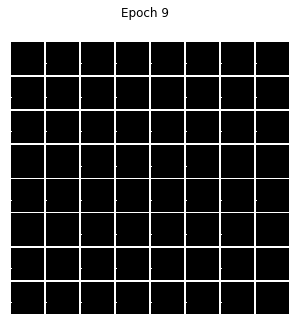

Epoch 10 batch 0 d 0.25 g 0.124816931784
Epoch 10 batch 50 d 0.250000178814 g 0.12499448657
Epoch 10 batch 100 d 0.250000268221 g 0.124999687076
Epoch 10 batch 150 d 0.250000298023 g 0.125004336238
Epoch 10 batch 200 d 0.250000327826 g 0.12500372529
Epoch 10 batch 250 d 0.250000327826 g 0.125001758337
Epoch 10 batch 300 d 0.250000357628 g 0.125002533197
Epoch 10 batch 350 d 0.250000357628 g 0.125002905726
Epoch 10 batch 400 d 0.250000327826 g 0.125003531575
Epoch 10 batch 450 d 0.250000327826 g 0.125003144145


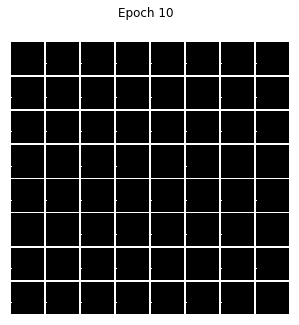

Epoch 11 batch 0 d 0.250000596046 g 0.125173911452
Epoch 11 batch 50 d 0.250000238419 g 0.124996468425
Epoch 11 batch 100 d 0.250000298023 g 0.124997772276
Epoch 11 batch 150 d 0.250000298023 g 0.125001117587
Epoch 11 batch 200 d 0.250000268221 g 0.12500230968
Epoch 11 batch 250 d 0.250000327826 g 0.125002011657
Epoch 11 batch 300 d 0.250000298023 g 0.125002563
Epoch 11 batch 350 d 0.250000268221 g 0.125002190471
Epoch 11 batch 400 d 0.250000298023 g 0.125003278255
Epoch 11 batch 450 d 0.250000268221 g 0.125003740191


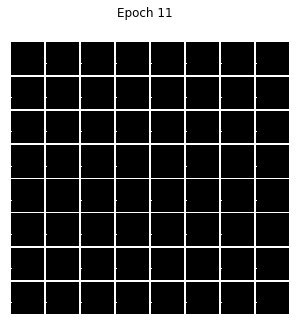

Epoch 12 batch 0 d 0.250000059605 g 0.125160306692
Epoch 12 batch 50 d 0.250000089407 g 0.125003263354
Epoch 12 batch 100 d 0.250000119209 g 0.125003129244
Epoch 12 batch 150 d 0.250000119209 g 0.125003278255
Epoch 12 batch 200 d 0.250000119209 g 0.125002160668
Epoch 12 batch 250 d 0.250000178814 g 0.125000938773
Epoch 12 batch 300 d 0.250000149012 g 0.125001862645
Epoch 12 batch 350 d 0.250000149012 g 0.125001564622
Epoch 12 batch 400 d 0.250000119209 g 0.125002071261
Epoch 12 batch 450 d 0.250000149012 g 0.12500153482


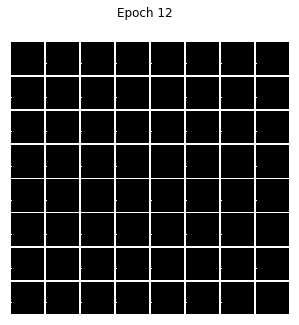

Epoch 13 batch 0 d 0.250000238419 g 0.125103071332
Epoch 13 batch 50 d 0.250000238419 g 0.125003054738
Epoch 13 batch 100 d 0.250000149012 g 0.124997891486
Epoch 13 batch 150 d 0.250000089407 g 0.125000536442
Epoch 13 batch 200 d 0.250000119209 g 0.125000566244
Epoch 13 batch 250 d 0.250000089407 g 0.124999798834
Epoch 13 batch 300 d 0.250000149012 g 0.124999694526
Epoch 13 batch 350 d 0.250000149012 g 0.12500025332
Epoch 13 batch 400 d 0.250000149012 g 0.125000208616
Epoch 13 batch 450 d 0.250000149012 g 0.125000089407


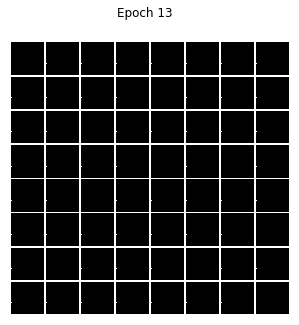

Epoch 14 batch 0 d 0.25 g 0.125032007694
Epoch 14 batch 50 d 0.250000089407 g 0.124997973442
Epoch 14 batch 100 d 0.250000119209 g 0.124998867512
Epoch 14 batch 150 d 0.250000089407 g 0.124999068677
Epoch 14 batch 200 d 0.250000089407 g 0.124999970198
Epoch 14 batch 250 d 0.250000149012 g 0.124999783933
Epoch 14 batch 300 d 0.250000149012 g 0.124999858439
Epoch 14 batch 350 d 0.250000149012 g 0.125000700355
Epoch 14 batch 400 d 0.250000178814 g 0.124998517334
Epoch 14 batch 450 d 0.250000178814 g 0.124998889863


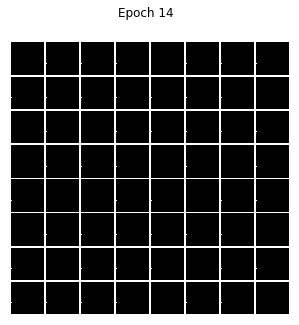

Epoch 15 batch 0 d 0.250000089407 g 0.12501502037
Epoch 15 batch 50 d 0.250000029802 g 0.125000312924
Epoch 15 batch 100 d 0.250000029802 g 0.124999709427
Epoch 15 batch 150 d 0.250000059605 g 0.125000879169
Epoch 15 batch 200 d 0.250000059605 g 0.125000342727
Epoch 15 batch 250 d 0.250000089407 g 0.125000223517
Epoch 15 batch 300 d 0.250000089407 g 0.124999850988
Epoch 15 batch 350 d 0.250000089407 g 0.125000044703
Epoch 15 batch 400 d 0.250000089407 g 0.12500025332
Epoch 15 batch 450 d 0.250000417233 g 0.125000759959


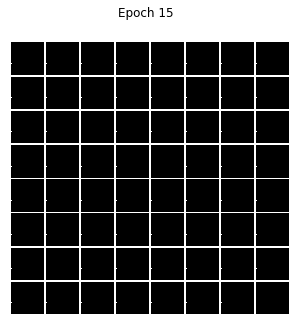

Epoch 16 batch 0 d 0.250001072884 g 0.125188738108
Epoch 16 batch 50 d 0.25000038743 g 0.125009819865
Epoch 16 batch 100 d 0.250000327826 g 0.125003695488
Epoch 16 batch 150 d 0.25000038743 g 0.125002071261
Epoch 16 batch 200 d 0.250001132488 g 0.125001460314
Epoch 16 batch 250 d 0.250001162291 g 0.12499755621
Epoch 16 batch 300 d 0.250000953674 g 0.124997645617
Epoch 16 batch 350 d 0.250000834465 g 0.124998033047
Epoch 16 batch 400 d 0.250000715256 g 0.124997794628
Epoch 16 batch 450 d 0.250000655651 g 0.124998241663


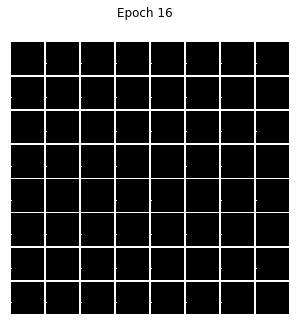

Epoch 17 batch 0 d 0.25 g 0.124967545271
Epoch 17 batch 50 d 0.25 g 0.125002667308
Epoch 17 batch 100 d 0.25 g 0.125001013279
Epoch 17 batch 150 d 0.25 g 0.125000447035
Epoch 17 batch 200 d 0.25 g 0.12500064075
Epoch 17 batch 250 d 0.25 g 0.124999970198
Epoch 17 batch 300 d 0.25 g 0.125000029802
Epoch 17 batch 350 d 0.25 g 0.125000268221
Epoch 17 batch 400 d 0.25 g 0.12500025332
Epoch 17 batch 450 d 0.25 g 0.124999806285


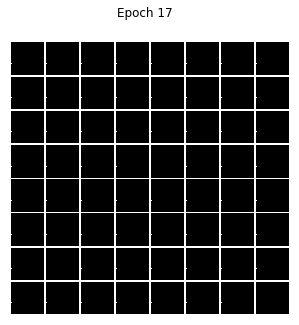

Epoch 18 batch 0 d 0.250000059605 g 0.125088825822
Epoch 18 batch 50 d 0.250000029802 g 0.125000596046
Epoch 18 batch 100 d 0.250000119209 g 0.124999150634
Epoch 18 batch 150 d 0.250000119209 g 0.124999068677
Epoch 18 batch 200 d 0.250000089407 g 0.124998934567
Epoch 18 batch 250 d 0.250000089407 g 0.124998942018
Epoch 18 batch 300 d 0.250000089407 g 0.124999091029
Epoch 18 batch 350 d 0.250000119209 g 0.124999307096
Epoch 18 batch 400 d 0.250000089407 g 0.124999597669
Epoch 18 batch 450 d 0.250000089407 g 0.12499987334


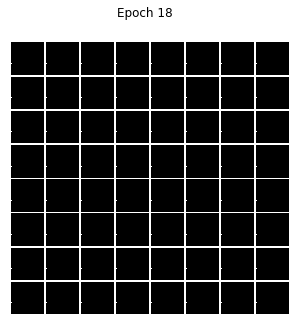

Epoch 19 batch 0 d 0.250000298023 g 0.125118911266
Epoch 19 batch 50 d 0.250000149012 g 0.125000119209
Epoch 19 batch 100 d 0.250000089407 g 0.125000029802
Epoch 19 batch 150 d 0.250000059605 g 0.124999962747
Epoch 19 batch 200 d 0.250000029802 g 0.124999716878
Epoch 19 batch 250 d 0.250000029802 g 0.124999724329
Epoch 19 batch 300 d 0.250000089407 g 0.12499974668
Epoch 19 batch 350 d 0.250000029802 g 0.124999850988
Epoch 19 batch 400 d 0.250007331371 g 0.125003159046
Epoch 19 batch 450 d 0.250028610229 g 0.125013113022


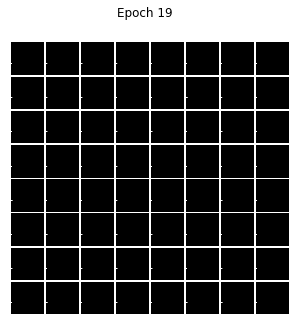

Epoch 20 batch 0 d 0.250000447035 g 0.125127285719
Epoch 20 batch 50 d 0.250000268221 g 0.125012338161
Epoch 20 batch 100 d 0.250000268221 g 0.125012591481
Epoch 20 batch 150 d 0.250000298023 g 0.12501090765
Epoch 20 batch 200 d 0.250000238419 g 0.125008374453
Epoch 20 batch 250 d 0.250000178814 g 0.125008478761
Epoch 20 batch 300 d 0.250000149012 g 0.125007763505
Epoch 20 batch 350 d 0.250000149012 g 0.125005885959
Epoch 20 batch 400 d 0.250000119209 g 0.125006094575
Epoch 20 batch 450 d 0.250000119209 g 0.12500539422


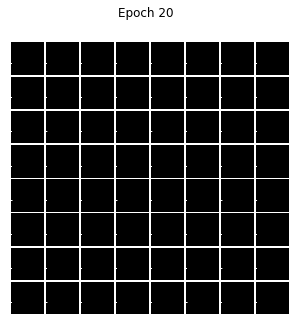

Epoch 21 batch 0 d 0.25 g 0.124967053533
Epoch 21 batch 50 d 0.25 g 0.12500038743
Epoch 21 batch 100 d 0.25 g 0.125001460314
Epoch 21 batch 150 d 0.25 g 0.125001564622
Epoch 21 batch 200 d 0.25 g 0.125001475215
Epoch 21 batch 250 d 0.25 g 0.125000834465
Epoch 21 batch 300 d 0.25 g 0.125000461936
Epoch 21 batch 350 d 0.25 g 0.125000834465
Epoch 21 batch 400 d 0.25 g 0.125000849366
Epoch 21 batch 450 d 0.25 g 0.12500089407


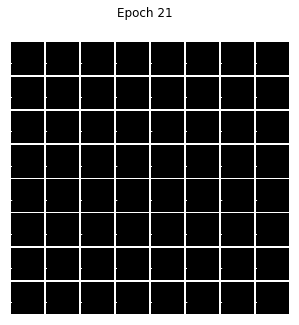

Epoch 22 batch 0 d 0.250000059605 g 0.125008791685
Epoch 22 batch 50 d 0.25 g 0.125000551343
Epoch 22 batch 100 d 0.25 g 0.124999925494
Epoch 22 batch 150 d 0.25 g 0.12500025332
Epoch 22 batch 200 d 0.25 g 0.125000432134
Epoch 22 batch 250 d 0.25 g 0.125000417233
Epoch 22 batch 300 d 0.25 g 0.125000447035
Epoch 22 batch 350 d 0.25 g 0.125000819564
Epoch 22 batch 400 d 0.25 g 0.125000506639
Epoch 22 batch 450 d 0.25 g 0.125000447035


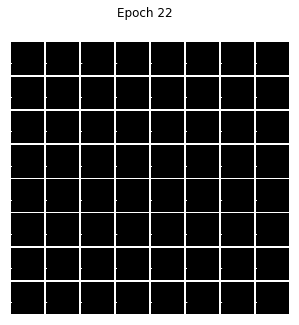

Epoch 23 batch 0 d 0.25 g 0.125002354383
Epoch 23 batch 50 d 0.25 g 0.125001445413
Epoch 23 batch 100 d 0.25 g 0.125000834465
Epoch 23 batch 150 d 0.25 g 0.125000849366
Epoch 23 batch 200 d 0.25 g 0.12500089407
Epoch 23 batch 250 d 0.25 g 0.125000864267
Epoch 23 batch 300 d 0.25 g 0.12500089407
Epoch 23 batch 350 d 0.25 g 0.125000625849
Epoch 23 batch 400 d 0.25 g 0.12500064075
Epoch 23 batch 450 d 0.25 g 0.125000581145


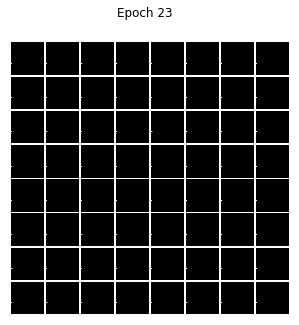

Epoch 24 batch 0 d 0.25 g 0.125030726194
Epoch 24 batch 50 d 0.25 g 0.125000968575
Epoch 24 batch 100 d 0.25 g 0.125001385808
Epoch 24 batch 150 d 0.25 g 0.125000968575
Epoch 24 batch 200 d 0.25 g 0.125000953674
Epoch 24 batch 250 d 0.25 g 0.125000849366
Epoch 24 batch 300 d 0.25 g 0.125000789762
Epoch 24 batch 350 d 0.25 g 0.125000745058
Epoch 24 batch 400 d 0.25 g 0.125000908971
Epoch 24 batch 450 d 0.25 g 0.125000834465


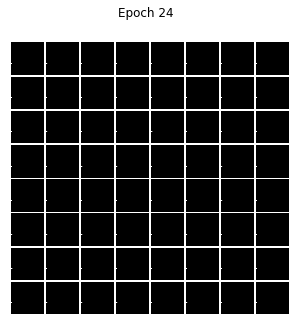

Epoch 25 batch 0 d 0.25 g 0.124982371926
Epoch 25 batch 50 d 0.25 g 0.124999903142
Epoch 25 batch 100 d 0.25 g 0.12499973923
Epoch 25 batch 150 d 0.25 g 0.125000700355
Epoch 25 batch 200 d 0.25 g 0.125000685453
Epoch 25 batch 250 d 0.25 g 0.125000819564
Epoch 25 batch 300 d 0.25 g 0.125000983477
Epoch 25 batch 350 d 0.25 g 0.125000923872
Epoch 25 batch 400 d 0.25 g 0.125000908971
Epoch 25 batch 450 d 0.25 g 0.125000789762


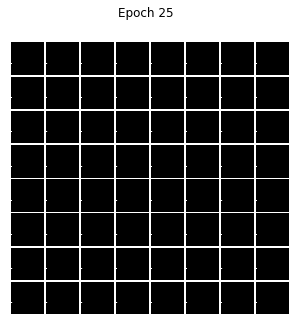

Epoch 26 batch 0 d 0.250000059605 g 0.125026285648
Epoch 26 batch 50 d 0.25 g 0.125001147389
Epoch 26 batch 100 d 0.25 g 0.125000312924
Epoch 26 batch 150 d 0.25 g 0.125000029802
Epoch 26 batch 200 d 0.25 g 0.125000149012
Epoch 26 batch 250 d 0.25 g 0.125000268221
Epoch 26 batch 300 d 0.25 g 0.125000447035
Epoch 26 batch 350 d 0.25 g 0.125000327826
Epoch 26 batch 400 d 0.25 g 0.125000491738
Epoch 26 batch 450 d 0.25 g 0.125000491738


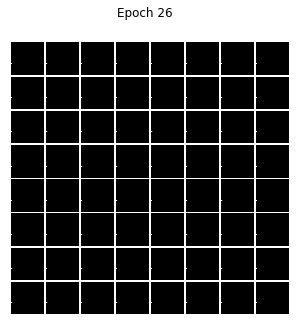

Epoch 27 batch 0 d 0.25 g 0.124988526106
Epoch 27 batch 50 d 0.25 g 0.125000417233
Epoch 27 batch 100 d 0.25 g 0.124999977648
Epoch 27 batch 150 d 0.25 g 0.125000149012
Epoch 27 batch 200 d 0.25 g 0.125000149012
Epoch 27 batch 250 d 0.25 g 0.124999940395
Epoch 27 batch 300 d 0.25 g 0.125
Epoch 27 batch 350 d 0.25 g 0.124999992549
Epoch 27 batch 400 d 0.25 g 0.124999955297
Epoch 27 batch 450 d 0.25 g 0.124999955297


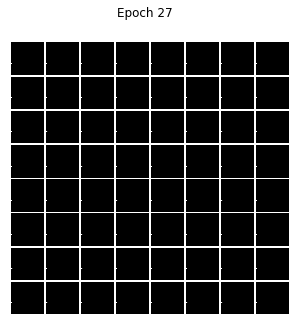

Epoch 28 batch 0 d 0.25 g 0.12499114871
Epoch 28 batch 50 d 0.25 g 0.125001356006
Epoch 28 batch 100 d 0.25 g 0.125000536442
Epoch 28 batch 150 d 0.250000029802 g 0.125000208616
Epoch 28 batch 200 d 0.250000029802 g 0.125000089407
Epoch 28 batch 250 d 0.250000089407 g 0.125000745058
Epoch 28 batch 300 d 0.250000089407 g 0.125000193715
Epoch 28 batch 350 d 0.250000089407 g 0.124999977648
Epoch 28 batch 400 d 0.250000089407 g 0.124999977648
Epoch 28 batch 450 d 0.250000059605 g 0.125000089407


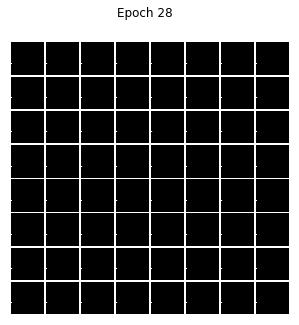

Epoch 29 batch 0 d 0.25 g 0.125012338161
Epoch 29 batch 50 d 0.25 g 0.125000491738
Epoch 29 batch 100 d 0.25 g 0.125000908971
Epoch 29 batch 150 d 0.25 g 0.125000625849
Epoch 29 batch 200 d 0.25 g 0.125000357628
Epoch 29 batch 250 d 0.250000059605 g 0.124999709427
Epoch 29 batch 300 d 0.250000089407 g 0.124999567866
Epoch 29 batch 350 d 0.250000089407 g 0.124999672174
Epoch 29 batch 400 d 0.250000089407 g 0.124999679625
Epoch 29 batch 450 d 0.250000059605 g 0.124999821186


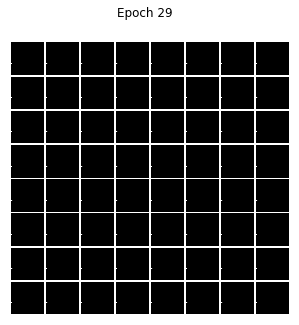

Epoch 30 batch 0 d 0.25 g 0.124975897372
Epoch 30 batch 50 d 0.25 g 0.124998629093
Epoch 30 batch 100 d 0.250000029802 g 0.124999597669
Epoch 30 batch 150 d 0.250000059605 g 0.125000730157
Epoch 30 batch 200 d 0.250000178814 g 0.124999605119
Epoch 30 batch 250 d 0.250000149012 g 0.124999850988
Epoch 30 batch 300 d 0.250000149012 g 0.124999597669
Epoch 30 batch 350 d 0.250001192093 g 0.124999783933
Epoch 30 batch 400 d 0.250002473593 g 0.125002622604
Epoch 30 batch 450 d 0.250002235174 g 0.125003561378


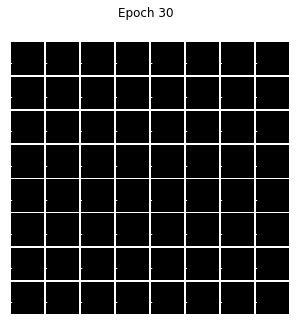

Epoch 31 batch 0 d 0.250000417233 g 0.125137642026
Epoch 31 batch 50 d 0.250000149012 g 0.1250038445
Epoch 31 batch 100 d 0.250000119209 g 0.12500141561
Epoch 31 batch 150 d 0.250000089407 g 0.125000625849
Epoch 31 batch 200 d 0.250000059605 g 0.12500025332
Epoch 31 batch 250 d 0.250000059605 g 0.125000581145
Epoch 31 batch 300 d 0.250000059605 g 0.125000149012
Epoch 31 batch 350 d 0.250000089407 g 0.125000014901
Epoch 31 batch 400 d 0.250000119209 g 0.125000670552
Epoch 31 batch 450 d 0.250000089407 g 0.125000506639


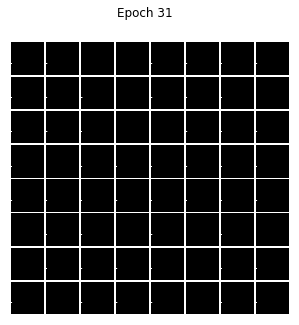

Epoch 32 batch 0 d 0.25 g 0.125017076731
Epoch 32 batch 50 d 0.25 g 0.124998122454
Epoch 32 batch 100 d 0.25 g 0.125000715256
Epoch 32 batch 150 d 0.25 g 0.125000581145
Epoch 32 batch 200 d 0.25 g 0.125000044703
Epoch 32 batch 250 d 0.25 g 0.125000014901
Epoch 32 batch 300 d 0.25 g 0.124999932945
Epoch 32 batch 350 d 0.25 g 0.124999716878
Epoch 32 batch 400 d 0.25 g 0.124999888241
Epoch 32 batch 450 d 0.25 g 0.124999910593


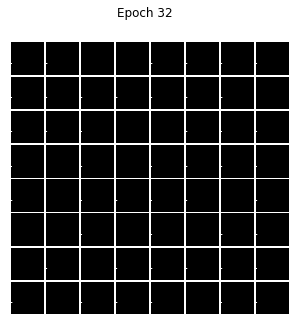

Epoch 33 batch 0 d 0.25 g 0.125008910894
Epoch 33 batch 50 d 0.25 g 0.125000983477
Epoch 33 batch 100 d 0.250000119209 g 0.125002756715
Epoch 33 batch 150 d 0.250036746264 g 0.125018745661
Epoch 33 batch 200 d 0.250271230936 g 0.125216811895
Epoch 33 batch 250 d 0.250227212906 g 0.1251565516
Epoch 33 batch 300 d 0.250190764666 g 0.125140622258
Epoch 33 batch 350 d 0.250164419413 g 0.125130400062
Epoch 33 batch 400 d 0.250144034624 g 0.125117719173
Epoch 33 batch 450 d 0.250128090382 g 0.125105708838


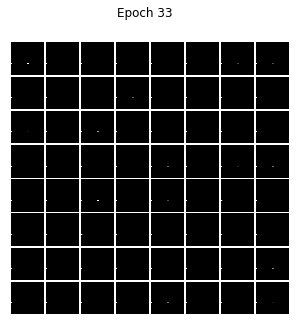

Epoch 34 batch 0 d 0.25000077486 g 0.12480700016
Epoch 34 batch 50 d 0.250000298023 g 0.12499511987
Epoch 34 batch 100 d 0.250000268221 g 0.125008255243
Epoch 34 batch 150 d 0.250000238419 g 0.125009700656
Epoch 34 batch 200 d 0.250000178814 g 0.125002220273
Epoch 34 batch 250 d 0.250000178814 g 0.125000238419
Epoch 34 batch 300 d 0.250000149012 g 0.125000044703
Epoch 34 batch 350 d 0.250000149012 g 0.124999552965
Epoch 34 batch 400 d 0.250000119209 g 0.124998174608
Epoch 34 batch 450 d 0.250000149012 g 0.12499897927


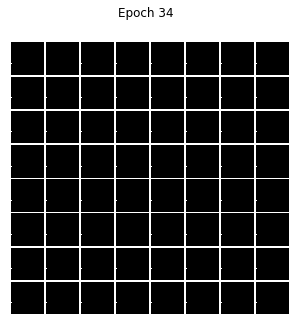

Epoch 35 batch 0 d 0.25 g 0.124997884035
Epoch 35 batch 50 d 0.250000029802 g 0.124998576939
Epoch 35 batch 100 d 0.250000029802 g 0.125000610948
Epoch 35 batch 150 d 0.250000059605 g 0.124999567866
Epoch 35 batch 200 d 0.250000029802 g 0.12499948591
Epoch 35 batch 250 d 0.250000029802 g 0.124999754131
Epoch 35 batch 300 d 0.250000029802 g 0.124998897314
Epoch 35 batch 350 d 0.250000029802 g 0.12499846518
Epoch 35 batch 400 d 0.250000029802 g 0.124998703599
Epoch 35 batch 450 d 0.250000029802 g 0.124999932945


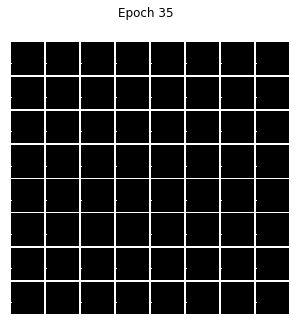

Epoch 36 batch 0 d 0.250000029802 g 0.125041782856
Epoch 36 batch 50 d 0.25 g 0.124999932945
Epoch 36 batch 100 d 0.25 g 0.124998688698
Epoch 36 batch 150 d 0.25 g 0.124999344349
Epoch 36 batch 200 d 0.25 g 0.124999552965
Epoch 36 batch 250 d 0.25 g 0.124999627471
Epoch 36 batch 300 d 0.25 g 0.124998964369
Epoch 36 batch 350 d 0.25 g 0.124999590218
Epoch 36 batch 400 d 0.250000029802 g 0.125000163913
Epoch 36 batch 450 d 0.250000029802 g 0.124999202788


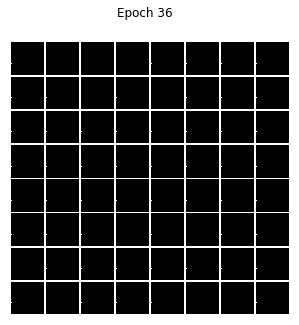

Epoch 37 batch 0 d 0.25 g 0.125008329749


In [ ]:
for epoch in range(1000):
    epoch_d_loss = []
    epoch_g_loss = []
    
    for i, real_image in enumerate(mnist_generator()):
        step = epoch * step_per_epoch + i
        
        # 训练D识别真实图片 
        r_d = exe.run(D_program, fetch_list=[D_loss], feed={
            'img': np.array(real_image),
            'z': np.array(next(z_generator))
        })
        epoch_d_loss.append(np.mean(r_d))
        
        ## 训练G生成符合D标准的“真实”图片
        r_g = exe.run(G_program, fetch_list=[G_loss], feed={
            'z': np.array(next(z_generator))
        })
        epoch_g_loss.append(np.mean(r_g))
        
        if i % 50 == 0:
            print("Epoch {} batch {} d {} g {}".format(
                epoch, i, np.mean(epoch_d_loss), np.mean(epoch_g_loss)
            ))
        
    # 测试
    r_i = exe.run(infer_program, fetch_list=[G_sample], feed={
        'z': test_z
    })
    show_image_grid(r_i[0], epoch)